In [17]:
#librerías, no es necesario volverlas a importar

import pandas as pd
import os
import gc
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
plt.style.use('ggplot')



from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.optimizers.schedules import ExponentialDecay
from keras import initializers, regularizers, constraints, optimizers, layers, Sequential
from keras.utils import plot_model
from sklearn.metrics import classification_report

from gensim.models import Word2Vec



In [3]:
data_loader = os.path.join('..','0_Data','0_DataLoader.ipynb')
#Vectorizacion
%run $data_loader

[nltk_data] Downloading package punkt to /home/celeste/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/celeste/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/celeste/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
def plot_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(x, acc, 'r', label='Training acc')
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training accuracy vs loss')
    plt.legend()

In [19]:
def run_model (train_x, train_y, val_x, val_y, test_x, test_y,
               embed_size, max_features, max_len, 
               batch_size, activationl1, nneuronsl1, epochs ):
    cores = multiprocessing.cpu_count() # Count the number of cores in a computer
    
    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_x) + list(val_x))

    train_X = tokenizer.texts_to_sequences(train_x)
    train_X = pad_sequences(train_X, maxlen=max_len)

    val_X = tokenizer.texts_to_sequences(val_x)
    val_X = pad_sequences(val_X, maxlen=max_len)
    
    test_X = tokenizer.texts_to_sequences(test_x)
    test_X = pad_sequences(test_X, maxlen=max_len)
    
    
    ## indice del vocabulario
    word_index = tokenizer.word_index

    ## para proecesarlo necesito una lista de palabras por  tweet
    tweets_list_train = [text_to_word_sequence(sentence) for sentence in train_x]
    tweets_list_val = [text_to_word_sequence(sentence) for sentence in val_x]
    
    tweets_all = tweets_list_train + tweets_list_val 

    ## creo el modelo de word2vec
    w2v_model = Word2Vec(min_count=20,
                         window=2,
                         size=embed_size,
                         sample=6e-5, 
                         alpha=0.03, 
                         min_alpha=0.0007, 
                         negative=20,
                         workers=cores-1)

    ## se genera el vocabulario

    w2v_model.build_vocab(tweets_all, progress_per=10000)

    # se entrena el modelo word2vec

    w2v_model.train(tweets_all, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

    word_vectors = w2v_model.wv

    #print("Number of word vectors: {}".format(len(word_vectors.vocab)))

    MAX_NB_WORDS = min(max_features, len(word_index)+1)

    wv_matrix = (np.random.rand(MAX_NB_WORDS, embed_size) - 0.5) / 5.0
    for word, i in word_index.items():
        if i >= MAX_NB_WORDS:
            continue
        try:
            embedding_vector = word_vectors[word]
            wv_matrix[i] = embedding_vector
        except:
            pass    


    model = Sequential()
    model.add(layers.Embedding(input_dim=MAX_NB_WORDS, 
                               output_dim=embed_size, 
                               input_length=max_len,
                              weights=[wv_matrix]))
    model.add(layers.Flatten())
    model.add(layers.Dense(nneuronsl1, activation=activationl1))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    lr_schedule = ExponentialDecay(
        0.001,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)
    opt = Adam(learning_rate=lr_schedule)
    #opt = SGD()
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  
                 )
    #model.summary()

    history = model.fit(train_X, train_y,
                        epochs=epochs,
                        batch_size=batch_size,
                       validation_data=(val_X, val_y),
                       verbose=False)

    #plot_history(history)

    loss, accuracy = model.evaluate(train_X, train_y, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    
    loss, accuracy = model.evaluate(test_X, test_y, verbose=False)
    print("Testing Accuracy: {:.4f}".format(accuracy))
    test_pred_y = (model.predict(test_X, batch_size=1024, verbose=1) > 0.5).astype("int32")
    print("Report: \n{}".format(classification_report(test_y, test_pred_y)))
    return model, tokenizer

# 1. Datos Originales


In [6]:
# Se cargan los datos 

data = get_data_original_as_np_array()

## 1.1 Comienzo con una cantidad de parametros grande


In [12]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 300, max_features=20000, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9975
Testing Accuracy: 0.7689


## 1.2 Busco reducir la cantidad de parametros para reducir el overfitting

### 1.2.1 pruebo reduciendo max_features

In [20]:
model1, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 100, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9938
Testing Accuracy: 0.7853
2/2 [==============================] - 0s 12ms/step
Report: 
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       869
           1       0.80      0.67      0.73       654

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523



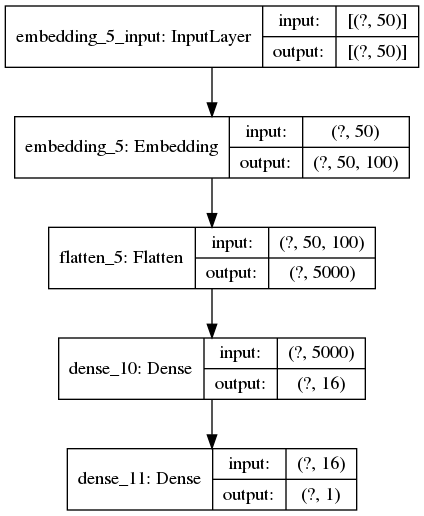

In [21]:
plot_model(model1, to_file='PerceptronWord2Vec.png', show_shapes=True)

In [14]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 100, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9940
Testing Accuracy: 0.7787


### 1.2.2 Pruebo reduciendo embed_size 

- Tamaño del vector de embeddings

In [35]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 100, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9953
Testing Accuracy: 0.7853


In [1]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 90, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

NameError: name 'run_model' is not defined

In [37]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 80, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9949
Testing Accuracy: 0.7754


In [38]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 70, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9951
Testing Accuracy: 0.7846


In [40]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 60, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9945
Testing Accuracy: 0.7787


# 2. Datos Preprocesados

In [41]:
# Se cargan los datos 

data = get_data_sentiment_analysis_as_np_array()


## 2.1 Comienzo con una cantidad de parametros grande

In [72]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 300, max_features=30000, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9891
Testing Accuracy: 0.7754


## 2.2. Busco reducir la cantidad de parametros para reducir el overfitting

In [43]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 300, max_features=13000, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9871
Testing Accuracy: 0.7058


In [44]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 300, max_features=12000, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9828
Testing Accuracy: 0.7039


In [46]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 300, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9893
Testing Accuracy: 0.7846


In [47]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 200, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9881
Testing Accuracy: 0.7748


In [48]:
model, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 100, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9887
Testing Accuracy: 0.7748


In [22]:
model2, tokenizer = run_model(data.x_train,data.y_train, data.x_val, data.y_val, data.x_test, data.y_test,
                             embed_size = 70, max_features=12500, max_len = 50,
                            batch_size = 512, nneuronsl1=16, activationl1='relu', epochs=20)

Training Accuracy: 0.9945
Testing Accuracy: 0.7846
2/2 [==============================] - 0s 2ms/step
Report: 
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       869
           1       0.78      0.69      0.73       654

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523



In [50]:
pred_X = tokenizer.texts_to_sequences(data.predict)
pred_X = pad_sequences(pred_X, maxlen=50)

y_pred = (model.predict(pred_X, batch_size=512, verbose=1) > 0.5).astype("int32")

7/7 [==============================] - 0s 2ms/step


In [51]:
submission = pd.read_csv(os.path.join('..','0_Data','dataset','sample_submission.csv'))
submission['target'] = y_pred
submission.to_csv("submission8.csv", index=False)